# 21 Plotting the Training and Validation Loss Curves for the Transformer Model

In [1]:
from pickle import HIGHEST_PROTOCOL, dump, load
from time import time

from matplotlib.pylab import plt
from numpy import arange, savetxt
from numpy.random import shuffle
from tensorflow import (
    GradientTape,
    argmax,
    cast,
    convert_to_tensor,
    data,
    equal,
    float32,
    function,
    int64,
    math,
    reduce_sum,
    train,
)
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from xformer.model import Xformer

## 2.1 Preparing the Training, Validation, and Testing Splits of the Dataset

We need a validation set. So let's modify the code from last chapter to include that. We will also save the encoder/decoder tokenizers as well as the test dataset (as pickle files and a text file, respectively) so we can use them in the inference stage (in the next chapter).

In [2]:
class PrepareDataset:
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.n_sentences = (
            10_000  # Number of sentences to include in the dataset
        )
        self.train_split = 0.8  # Ratio of the training data split
        self.val_split = 0.1  # Ratio of the validation data split

    # Fit a tokenizer
    def create_tokenizer(self, dataset):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(dataset)
        return tokenizer

    def find_seq_length(self, dataset):
        return max(len(seq.split()) for seq in dataset)

    def find_vocab_size(self, tokenizer, dataset):
        tokenizer.fit_on_texts(dataset)
        return len(tokenizer.word_index) + 1

    # Encode and pad the input sequences
    def encode_and_pad(self, dataset, tokenizer, seq_length):
        x = tokenizer.texts_to_sequences(dataset)
        x = pad_sequences(x, maxlen=seq_length, padding="post")
        x = convert_to_tensor(x, dtype=int64)
        return x

    def save_tokenizer(self, tokenizer, name, path="./"):
        if path[-1] != "/":
            path += "/"
        with open(path + name + "_tokenizer.pkl", "wb") as handle:
            dump(tokenizer, handle, protocol=HIGHEST_PROTOCOL)

    def __call__(self, filename, **kwargs):
        # Load a clean dataset
        clean_dataset = load(open(filename, "rb"))

        # Reduce dataset size
        dataset = clean_dataset[: self.n_sentences, :]

        # Include start and end of string tokens
        # Note: The book uses <START> but that is no good since it will be
        # cleaned and lowercased to "start" and get mixed up with the actual
        # English word "start", which does appear in the training data.
        for i in range(dataset[:, 0].size):
            dataset[i, 0] = "<SEQSTART> " + dataset[i, 0] + " <EOS>"
            dataset[i, 1] = "<SEQSTART> " + dataset[i, 1] + " <EOS>"

        # Random shuffle the dataset
        shuffle(dataset)

        # Split the dataset in training, validation and test sets
        train = dataset[: int(self.n_sentences * self.train_split)]
        val = dataset[
            int(self.n_sentences * self.train_split) : int(
                self.n_sentences * (1 - self.val_split)
            )
        ]
        test = dataset[int(self.n_sentences * (1 - self.val_split)) :]

        # Prepare tokenizer for the encoder input
        enc_tokenizer = self.create_tokenizer(dataset[:, 0])
        enc_seq_length = self.find_seq_length(dataset[:, 0])
        enc_vocab_size = self.find_vocab_size(enc_tokenizer, train[:, 0])

        # Prepare tokenizer for the decoder input
        dec_tokenizer = self.create_tokenizer(dataset[:, 1])
        dec_seq_length = self.find_seq_length(dataset[:, 1])
        dec_vocab_size = self.find_vocab_size(dec_tokenizer, train[:, 1])

        # Encode and pad the training input
        trainX = self.encode_and_pad(train[:, 0], enc_tokenizer, enc_seq_length)
        trainY = self.encode_and_pad(train[:, 1], dec_tokenizer, dec_seq_length)

        # Encode and pad the validation input
        valX = self.encode_and_pad(val[:, 0], enc_tokenizer, enc_seq_length)
        valY = self.encode_and_pad(val[:, 1], dec_tokenizer, dec_seq_length)

        # Save the encoder tokenizer
        self.save_tokenizer(enc_tokenizer, "enc", "data/")

        # Save the decoder tokenizer
        self.save_tokenizer(dec_tokenizer, "dec", "data/")

        # Save the testing dataset into a text file
        savetxt("data/test_dataset.txt", test, fmt="%s")

        return (
            trainX,
            trainY,
            valX,
            valY,
            train,
            val,
            enc_seq_length,
            dec_seq_length,
            enc_vocab_size,
            dec_vocab_size,
        )

## 2.2 Training the Transformer Model

Likewise we need to make some modifications to the training code from last chapter to account for validation accuracy, loss, etc. Also, we will save the trained model weights at every epoch because we want to be able to analyze and compare how well the model did at different points as it got trained. In practice, we would probably use a callback instead and only save the weights periodically and also to stop early if certain conditions are reached (e.g. the model is no longer learning).

In [3]:
# Define the model parameters
h = 8  # Number of self-attention heads
d_model = 512  # Dimensionality of model layers' outputs
d_ff = 2048  # Dimensionality of the inner fully connected layer
n = 6  # Number of layers in the encoder stack

# Define the training parameters
epochs = 20
batch_size = 64
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
dropout_rate = 0.1

# Implementing a learning rate scheduler
class LRScheduler(LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, **kwargs):
        super().__init__(**kwargs)
        self.d_model = cast(d_model, float32)
        self.warmup_steps = cast(warmup_steps, float32)

    def __call__(self, step_num):
        # Linearly increasing the learning rate for the first warmup_steps, and
        # decreasing it thereafter
        step_num = cast(step_num, float32)
        arg1 = step_num**-0.5
        arg2 = step_num * (self.warmup_steps**-1.5)

        return (self.d_model**-0.5) * math.minimum(arg1, arg2)


# Instantiate an Adam optimizer
optimizer = Adam(LRScheduler(d_model), beta_1, beta_2, epsilon)

# Prepare the training dataset
dataset = PrepareDataset()
(
    trainX,
    trainY,
    valX,
    valY,
    train_orig,
    val_orig,
    enc_seq_length,
    dec_seq_length,
    enc_vocab_size,
    dec_vocab_size,
) = dataset("data/english-german-both.pkl")

print(
    f"{enc_seq_length=}, {dec_seq_length=}, {enc_vocab_size=},"
    f" {dec_vocab_size=}"
)

# Prepare the training dataset batches
train_dataset = data.Dataset.from_tensor_slices((trainX, trainY))
train_dataset = train_dataset.batch(batch_size)

# Prepare the validation dataset batches
val_dataset = data.Dataset.from_tensor_slices((valX, valY))
val_dataset = val_dataset.batch(batch_size)

# Create model
training_model = Xformer(
    enc_vocab_size,
    dec_vocab_size,
    enc_seq_length,
    dec_seq_length,
    h,
    d_model,
    d_ff,
    n,
    dropout_rate,
)

# Defining the loss function
def loss_fn(target, prediction):
    # Create mask so that the zero padding values are not included in the
    # computation of loss
    mask = math.logical_not(equal(target, 0))
    mask = cast(mask, float32)

    # Compute a sparse categorical cross-entropy loss on the unmasked values
    loss = (
        sparse_categorical_crossentropy(target, prediction, from_logits=True)
        * mask
    )

    # Compute the mean loss over the unmasked values
    return reduce_sum(loss) / reduce_sum(mask)


# Defining the accuracy function
def accuracy_fn(target, prediction):
    # Create mask so that the zero padding values are not included in the
    # computation of accuracy
    mask = math.logical_not(equal(target, 0))

    # Find equal prediction and target values, and apply the padding mask
    accuracy = equal(
        target, argmax(prediction, axis=2)
    )  # Should this be `argmax(prediction, axis=2) + 1` ??
    accuracy = math.logical_and(mask, accuracy)

    # Cast the True/False values to 32-bit-precision floating-point numbers
    mask = cast(mask, float32)
    accuracy = cast(accuracy, float32)

    # Compute the mean accuracy over the unmasked values
    return reduce_sum(accuracy) / reduce_sum(mask)


# Include metrics monitoring
train_loss = Mean(name="train_loss")
train_accuracy = Mean(name="train_accuracy")
val_loss = Mean(name="val_loss")

# Create a checkpoint object and manager to manage multiple checkpoints
ckpt = train.Checkpoint(model=training_model, optimizer=optimizer)
ckpt_manager = train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=None)

# Initialise dictionaries to store the training and validation losses
train_loss_dict = {}
val_loss_dict = {}

# Speeding up the training process
@function
def train_step(encoder_input, decoder_input, decoder_output):
    with GradientTape() as tape:
        # Run the forward pass of the model to generate a prediction
        prediction = training_model(encoder_input, decoder_input, training=True)

        # Compute the training loss
        loss = loss_fn(decoder_output, prediction)

        # Compute the training accuracy
        accuracy = accuracy_fn(decoder_output, prediction)

    # Retrieve gradients of the trainable variables with respect to the training loss
    gradients = tape.gradient(loss, training_model.trainable_weights)

    # Update the values of the trainable variables by gradient descent
    optimizer.apply_gradients(zip(gradients, training_model.trainable_weights))
    train_loss(loss)
    train_accuracy(accuracy)


start_time = time()
for epoch in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    print("\nStart of epoch %d" % (epoch + 1))

    # Iterate over the dataset batches
    for step, (train_batchX, train_batchY) in enumerate(train_dataset):
        # Define the encoder and decoder inputs, and the decoder output
        encoder_input = train_batchX[:, 1:]
        decoder_input = train_batchY[:, :-1]
        decoder_output = train_batchY[:, 1:]

        train_step(encoder_input, decoder_input, decoder_output)

        if step % 50 == 0:
            print(
                f"Epoch {epoch + 1} Step {step} Loss {train_loss.result():.4f} "
                + f"Accuracy {train_accuracy.result():.4f}"
            )

    # Run a validation step after every epoch of training
    for val_batchX, val_batchY in val_dataset:
        # Define the encoder and decoder inputs, and the decoder output
        encoder_input = val_batchX[:, 1:]
        decoder_input = val_batchY[:, :-1]
        decoder_output = val_batchY[:, 1:]

        # Generate a prediction
        prediction = training_model(
            encoder_input, decoder_input, training=False
        )

        # Compute the validation loss
        loss = loss_fn(decoder_output, prediction)
        val_loss(loss)

    # Print epoch number and accuracy and loss values at the end of every epoch
    print(
        f"Epoch {epoch+1}: Training Loss {train_loss.result():.4f}, "
        + f"Training Accuracy {train_accuracy.result():.4f}, "
        + f"Validation Loss {val_loss.result():.4f}"
    )

    # Save a checkpoint after every epoch
    if (epoch + 1) % 1 == 0:
        save_path = ckpt_manager.save()
        print(f"Saved checkpoint at epoch {epoch+1}")

        # Save the trained model weights
        training_model.save_weights("weights/wghts" + str(epoch + 1) + ".ckpt")

        train_loss_dict[epoch] = train_loss.result()
        val_loss_dict[epoch] = val_loss.result()

# Save the training loss values
with open("./train_loss.pkl", "wb") as file:
    dump(train_loss_dict, file)

# Save the validation loss values
with open("./val_loss.pkl", "wb") as file:
    dump(val_loss_dict, file)

print("Total time taken: %.2fs" % (time() - start_time))

enc_seq_length=7, dec_seq_length=12, enc_vocab_size=2405, dec_vocab_size=3864

Start of epoch 1
Epoch 1 Step 0 Loss 8.4326 Accuracy 0.0000
Epoch 1 Step 50 Loss 7.5542 Accuracy 0.1401
Epoch 1 Step 100 Loss 6.9841 Accuracy 0.1799
Epoch 1: Training Loss 6.8204, Training Accuracy 0.1878, Validation Loss 5.9698
Saved checkpoint at epoch 1

Start of epoch 2
Epoch 2 Step 0 Loss 5.9778 Accuracy 0.2246
Epoch 2 Step 50 Loss 5.6905 Accuracy 0.2498
Epoch 2 Step 100 Loss 5.4951 Accuracy 0.2586
Epoch 2: Training Loss 5.4154, Training Accuracy 0.2620, Validation Loss 4.9853
Saved checkpoint at epoch 2

Start of epoch 3
Epoch 3 Step 0 Loss 4.9549 Accuracy 0.2982
Epoch 3 Step 50 Loss 4.9012 Accuracy 0.2847
Epoch 3 Step 100 Loss 4.8459 Accuracy 0.2893
Epoch 3: Training Loss 4.8165, Training Accuracy 0.2910, Validation Loss 4.7008
Saved checkpoint at epoch 3

Start of epoch 4
Epoch 4 Step 0 Loss 4.6509 Accuracy 0.3228
Epoch 4 Step 50 Loss 4.6159 Accuracy 0.3041
Epoch 4 Step 100 Loss 4.5972 Accuracy 0.303

## 21.3 Plotting the Training and Validation Loss Curves

Let's plot the validation and training losses to check for underfitting/overfitting.

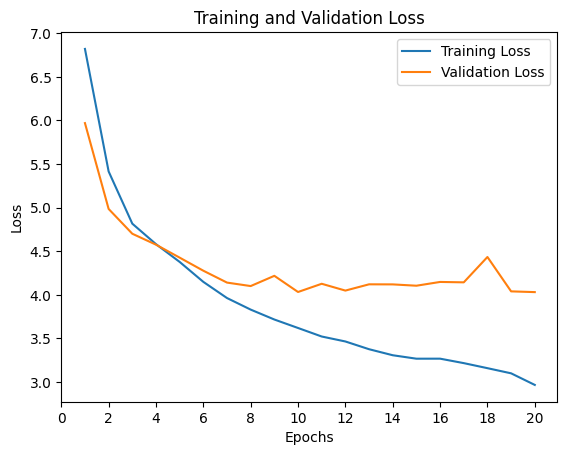

In [4]:
# Load the training and validation loss dictionaries
train_loss = load(open('train_loss.pkl', 'rb'))
val_loss = load(open('val_loss.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_loss.values()
val_values = val_loss.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 21)

# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 21, 2))

# Display the plot
plt.legend(loc='best')
plt.show()